# Train Keras model and make performance plots

In [3]:
#Data Processing
import numpy as np
from numpy import loadtxt, expand_dims
import h5py
import sys

#ML model
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense,Flatten, Dropout, Activation, concatenate, BatchNormalization, GRU, Add, Conv1D, Conv2D, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model


from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

#Just to efficiently save plots
plot_dir = "../plot/"
print("Saving plot to: ", plot_dir)
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

Saving plot to:  ../plot/


## 1. Train model

In [4]:
#Load in the datasets for training and compiling the sample weights
with h5py.File('../data/trainingDataTTdXYPup.h5', 'r') as hf:
    dataset = hf["Training Data"][:]
with h5py.File('../data/sampleDataTTdXYPup.h5', 'r') as hf:
    sampleData = hf["Sample Data"][:]
    

#Separate datasets into inputs and outputs, expand the dimensions of the inputs to be used with Conv1D layers
X = dataset[:,0:len(dataset[0])-1]
X = expand_dims(X, axis=2)
y = dataset[:,len(dataset[0])-1]

print("X shape: ", X.shape)
print("y shape: ", y.shape)

#Establish the sample weights
thebins = np.linspace(0, 200, 100)
bkgPts = []
sigPts = []
for i in range(len(sampleData)):
    if y[i]==1:
        sigPts.append(sampleData[i][0])
    if y[i]==0:
        bkgPts.append(sampleData[i][0])
bkg_counts, binsbkg = np.histogram(bkgPts, bins=thebins)
sig_counts, binssig = np.histogram(sigPts, bins=thebins)
a = []
for i in range(len(bkg_counts)):
    tempSig = float(sig_counts[i])
    tempBkg = float(bkg_counts[i])
    if tempBkg!=0:
        a.append(tempSig/tempBkg)
    if tempBkg==0:
        a.append(0)
        
#Normalize the sample weights above a certain pT
for i in range(42,len(a)):
    a[i]=0.7
    
#Add in the sample weights, 1-to-1 correspondence with training data
#Sample weight of all signal events being equal to 1
#Sample weight of all background events being equal to the sig/bkg ratio at that jet's pT
weights = []
for i in range(len(sampleData)):
    if y[i]==1:
        weights.append(1)
    if y[i]==0:
        jetPt = sampleData[i][0]
        tempPt = int(jetPt/2)
        if tempPt>98:
            tempPt = 98
        weights.append(a[tempPt])

X shape:  (389705, 130, 1)
y shape:  (389705,)


In [5]:
#Define the model
model = Sequential()
model.add(Conv1D(filters=20, kernel_size=13, strides=13, activation='relu',input_shape=(len(dataset[0])-1,1)))
model.add(Conv1D(filters=5, kernel_size=1,activation='relu'))
model.add(Flatten())
model.add(Dense(20, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 20)            280       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 5)             105       
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1020      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,626
Trainable params: 1,626
Non-trainable params: 0
______________________________________________________

In [6]:
#Train the network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)

model.fit(X,y,
          epochs=50,
          batch_size=50,
          verbose=2,
          sample_weight=np.asarray(weights),
          validation_split=0.20,
          callbacks=[callback])

Epoch 1/50
6236/6236 - 17s - loss: 0.5049 - binary_accuracy: 0.6423 - val_loss: 0.4913 - val_binary_accuracy: 0.6722
Epoch 2/50
6236/6236 - 12s - loss: 0.4876 - binary_accuracy: 0.6685 - val_loss: 0.4865 - val_binary_accuracy: 0.6733
Epoch 3/50
6236/6236 - 12s - loss: 0.4837 - binary_accuracy: 0.6725 - val_loss: 0.4875 - val_binary_accuracy: 0.6858
Epoch 4/50
6236/6236 - 12s - loss: 0.4813 - binary_accuracy: 0.6747 - val_loss: 0.4816 - val_binary_accuracy: 0.6702
Epoch 5/50
6236/6236 - 12s - loss: 0.4789 - binary_accuracy: 0.6761 - val_loss: 0.4860 - val_binary_accuracy: 0.6493
Epoch 6/50
6236/6236 - 12s - loss: 0.4770 - binary_accuracy: 0.6766 - val_loss: 0.4799 - val_binary_accuracy: 0.6622
Epoch 7/50
6236/6236 - 12s - loss: 0.4745 - binary_accuracy: 0.6788 - val_loss: 0.4775 - val_binary_accuracy: 0.6699
Epoch 8/50
6236/6236 - 11s - loss: 0.4720 - binary_accuracy: 0.6817 - val_loss: 0.4730 - val_binary_accuracy: 0.6816
Epoch 9/50
6236/6236 - 11s - loss: 0.4700 - binary_accuracy: 0.6

In [7]:
model.save('../saved_model/L1BTagModel_Flatten_LargerTinyv2_TTdXYPup.h5')

## 2. Make performance plot for the model

In [8]:
#Establish the input and output data for each dataset, expanding dimensions for compatability with Conv1D layer input
def load_testing_data(data_path):
    
    with h5py.File(data_path, 'r') as hf:
        dataset = hf["Testing Data"][:]
    X_test = dataset[:,0:len(dataset[0])-1]
    X_test = expand_dims(X_test, axis=2)
    y_test = dataset[:,len(dataset[0])-1]
    
    return X_test, y_test

X_test, y_test = load_testing_data('../data/testingDataTTdXYPup.h5')

In [9]:
#Load in respective model for the datasets
#model_1 = load_model('../saved_model/L1BTagModel_100GRU.h5')
model_2 = load_model('../saved_model/L1BTagModel_Flatten_LargerTinyv2_TTdXYPup.h5')

#Creating ROC curves based on model predictions for each dataset
#y_pred_1 = model_1.predict(X_test).ravel()
y_pred_2 = model_2.predict(X_test).ravel()

#fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_1)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_2)

#auc_1 = auc(fpr_1, tpr_1)
auc_2 = auc(fpr_2, tpr_2)

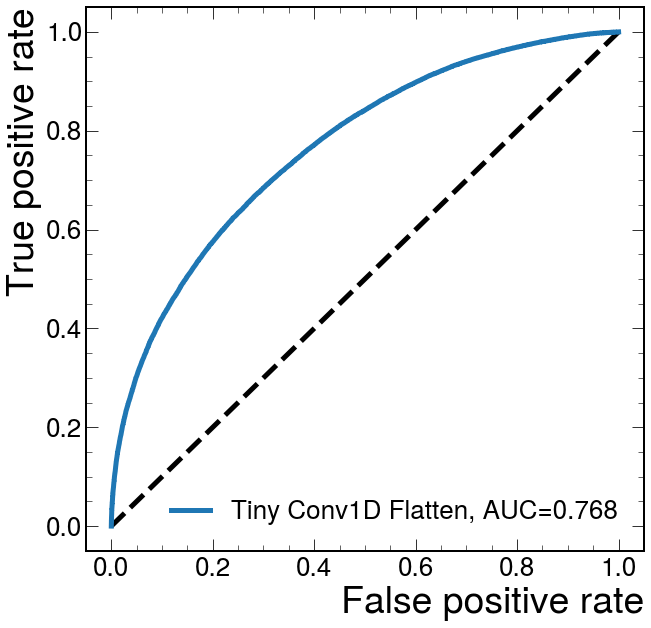

In [10]:
#Create plot for ROC
plt.figure(1)
plt.plot([0,1],[0,1],'k--')

#plt.plot(fpr_1, tpr_1, label='Conv1D 100GRU, AUC={:.3f}'.format(auc_1))
plt.plot(fpr_2, tpr_2, label='Tiny Conv1D Flatten, AUC={:.3f}'.format(auc_2))

#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

#p_path = save_path + "v2LargerTinyConv1D_100GRU_Flatten.pdf"
#print(p_path)
#plt.savefig(p_path, bbox_inches='tight')